# Final Project Baseline
**Project:** Facial Keypoints Detection

**Authors:** Richard Ryu, Nick Cirella, Diana Iftimie

**Team:** RnD

### Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## I. Introduction & Purpose

The purpose of this project is to develop a working model for solving the core Facial Keypoints Detection problem. At a high level, Facial Keypoints Detection is a task where given a image of a human face, a model analyzes the image and detects facial keypoints for the identified face. Such facial keypoints include the centers and corners of the eyes, the corners of the mouth, and the tip of the nose, among other facial key points. To accomplish this task, the model must predict coordinates (x, y) in the pixel space of the given image of a face.

As a computer vision problem, the Facial Keypoints Detection task has a wide variety of applications. From the basic task of identifying facial keypoints of a given image of a face, these results can be used to solve the task of identifying faces in images (a.k.a. facial recognition). These results then enable solving much more complex problems, including tracking (multiple) faces in videos (such as in security camera footage) and analyzing facial expressions in different faces (emotion understanding, which can be used in sentiment analysis based on camera footage). This technology can even extend to doing more complex biometrics analysis, which is heavily used to identify people simply using an image of their face, such as Microsoft's Face API & Windows Hello and Apple's Face ID for iPhones. Thus, accomplishing the facial keypoints detection task is central to much of the work done in this day and age on basic human understanding in computer vision. 

For the purpose of this project, we will focus on the Facial Keypoints Detection task as defined in the Kaggle Challenge linked here: https://www.kaggle.com/c/facial-keypoints-detection/overview/description

## II. High-Level Machine Learning Task

As mentioned above, the goal of this machine learning task is to accurately predict a set of facial keypoints as coordinates in pixel space, given an image of a face (the inference task). That is, we aim to develop a model (or multiple iterations of a model) that is able to learn generalized information about the facial keypoints detection task from a training set available on the kaggle challenge for Facial Keypoints Detection. For training, our input is a set of images of faces and our output is a set of facial keypoints that correspond to each image. We will train a model that is able to generally capture the relationship between input and output data in order to accomplish the inference task of detecting keypoints given new images of faces. 

## III. The Data (High-Level)

As described previously, our input data consists of images, both for training and test. We will refer to both of these datasets in the context of the Kaggle competition, as "Kaggle Competition Training" and "Kaggle Competition Test", as they are specifically related to the Kaggle Competition task. This will avoid confusing with the subsets of Kaggle Competition Training data that we will use for actual model training, hyperparameter tuning, and evaluation. 

### Kaggle Competition Training Data

In [2]:
# Load and display training data
kaggle_competition_training_data = pd.read_csv('data/training/training.csv')
print("Kaggle Competition Training Data Shape: ", kaggle_competition_training_data.shape)
kaggle_competition_training_data.head(1)

Kaggle Competition Training Data Shape:  (7049, 31)


,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...


For the Kaggle Competition Training data that is available for constructing our model, we have a total of `7049` images to consider when training our model(s). Each of thse images are `96x96` pixels in dimension, with the pixel values organized as lists of row-ordered pixel values ranging between `(0, 255)` (for a total of `9216` values) which lives in the `Image` column of the table (the right-most column). The structure of the pixel values is very similar to that seen in the MNIST dataset in Project 1. 

In addition to the `Image` column with the actual image data, we see the first 30 columns correspond to 15 facial keypoints (each pair of columns correspond to the `x` and `y` pixel coordinates of one facial keypoint). For example, the first column indicates `left_eye_center_x` and the second column indicates `left_eye_center_y`, which in combination correspond to coodinates (`x`, `y`) of the facial keypoint for the center of the left eye.

With this data, we have both the input (images) and the correct output (facial keypoints labels) that can be used to train our model(s). In order to properly evaluate our model and keep it from overfitting, we will split this data into train, dev, and test sets.

Below is an example image and its corresponding facial keypoints:

In [6]:
# WARNING: This takes quite some time to run
# Loop to re-store all image values in comma separated list object
training_image_list = []
for i in range(len(kaggle_competition_training_data["Image"])):
    training_image_list.append(kaggle_competition_training_data["Image"][i].split(" "))

# reshaping the image list object into array
training_image_array = np.array(training_image_list, dtype = 'float')
len(training_image_array)

7049

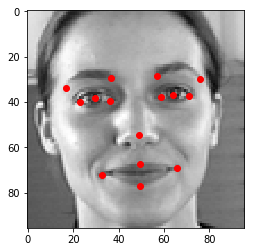

In [7]:
# plotting a sample image and associated facial points into 96x96 after reshaping them
feature_list = list(kaggle_competition_training_data)
feature_list.remove("Image")
# hardcoded to the 10th image
plt.imshow(training_image_array[9].reshape(96,96), cmap='gray')
for i in feature_list[::2]:
    plt.plot(kaggle_competition_training_data[i[:-1]+'x'][9], 
             kaggle_competition_training_data[i[:-1]+'y'][9], 'o', color='red')

#### Dealing with Missing Facial Keypoints

Upon closer inspection of the Kaggle Competition Training Data, there are some samples in the dataset that do not have all 15 facial keypoints recorded--some of them are missing. As a result, this will affects how we end up doing model evaluation (namely, we do not know what the groud-truth labels are for those keypoints that are missing, even though the model will predict those keypoints). 

Unfortunately, our training dataset contains vast amount of null values for various features. To summarize, features starting from 'left_eye_inner_corner_x' to 'right_eyebrow_outer_end_y' has about 4780 null values and close to all of mouth features also had about 4780 null values. Fortunately, there were no null values for the images and nose features. This affects the evaluation of our models (namely, we do not know what the groud-truth labels are for those keypoints that are missing, even though the model will predict those keypoints). We will either have to exclude some images or apply feature engineering to address the null values.

In [3]:
# Checking for null values in our dataset
isnulls = kaggle_competition_training_data.isnull()
isnulls_sum = isnulls.sum()
print("Number of Null Values for Each Feature\n\n",isnulls_sum)

Number of Null Values for Each Feature

 left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
left_eyebrow_inner_end_x     4779
left_eyebrow_inner_end_y     4779
left_eyebrow_outer_end_x     4824
left_eyebrow_outer_end_y     4824
right_eyebrow_inner_end_x    4779
right_eyebrow_inner_end_y    4779
right_eyebrow_outer_end_x    4813
right_eyebrow_outer_end_y    4813
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          4780
mouth_left_corner_y          4780
mouth_right_corner_x         4779
mouth_right_corner_y         4779
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_c

### Kaggle Competition Test Data

In [4]:
kaggle_competition_test_data = pd.read_csv('data/test/test.csv')
print("Kaggle Competition Test Data Shape: ", kaggle_competition_test_data.shape)
kaggle_competition_test_data.head(1)

Kaggle Competition Test Data Shape:  (1783, 2)


,ImageId,Image
0,1,182 183 182 182 180 180 176 169 156 137 124 10...


In [5]:
# testing for null values in test data
testnulls = kaggle_competition_test_data.isnull()
testnulls_sum = testnulls.sum()
print("Number of Null Values for Each Feature\n\n",testnulls_sum)

Number of Null Values for Each Feature

 ImageId    0
Image      0
dtype: int64


Furthermore, we have the Kaggle Competition Test data provided to use, which is used for the final evaluation stage in the competition. In this dataset, we have a total of `1783` images that are also `96x96` pixels in dimension, the pixel values organized as lists of row-ordered pixel values ranging between `(0, 255)` that live in the `Image` column of the tabe (the right-most column. 

Unlike the Kaggle Competition Training data, we do not have facial keypoints as lables, and instead, we only have and `ImageId` associated with each image. This is because for the actual Kaggle Competition Submission, we will need to use our model constructed from the Kaggle Competition Training data and predict facial keypoints for each of the entries in the Kaggle Competition Test dataset. Thus, only Kaggle has the "correct labels", and we will not be able to do any evaluation on this dataset; this datset will be used for submission only.

## IV. Feature Engineering

Because our input data for this task consists of images, we will focus our feature engineering to leveral image processing techniques, such as those seen in Project 1 for the MNIST dataset.

Starting from the arrays of raw pixel values that describe each image, we will investigate some of the following techniques for feature engineering and pre-processing these images:
 * Normalizing pixel values (have them range between (0.0, 1.0))
 * Gaussian Blur (or other blurring techniques)
 * Binning pixel values (e.g. [0, 99] -> 0, [100, 199] -> 1, [200, 255] -> 2)
 * Adding Gaussian Noise (or other type of noise)
 * Singular Value Decomposition / Principal Component Analysis (and use top n principal components to describe images)

We go into more details of each of the possible techniques below.

### Normalizing Pixel Values
In order to ensure that features are represented consistently between images by ensuring that the minimum/maximum values of the grayscale used in each image are consistent.  Pixels range between 0 and 255.  The goal of this process is to ensure that all of the images are using the same range for color scale.  Since we’ll compare features based on pixel color, ensuring that the high/low range of the pixels in each image are consistent will allow the model to make an apples-to-apples comparison.  By picking a high and a low of the range for each image we can distribute the existing pixels across that range (either expanding or contracting the original range), while maintaining the same underlying image. 
 
### Blurring Images
Images with high contrast, by definition, have a large delta between adjacent or nearby pixels.  While this can improve the quality of an image visually, taking this too far can make an image unrecognizable.  By adjusting each pixel to decrease the relative range between that pixel and the surrounding pixels we can increase the relationship between pixels, improving the contract for the algorithm and removing noise.
Similarly, when evaluating images using algorithms, high variance between pixels can lead to significant noise.  This noise can obscure important general trends in an image due to the high individual variance between smaller ranges of pixels.  Blurring the image adds relational data to pixels in a predetermined range.  Similar to adjusting contract to improve image clarity for visual recognition, blurring does the same for our algorithms, potentially improving the ability of the algorithm to recognize important ranges of pixels as part of the training process.


### Binning Pixel Values
Binning is similar to blurring, however, instead of decreasing the range between pixels binning essentially expands the size of a pixel.  For instance, a binning algorithm may take the average of each box of 4 pixels and set each of those pixels to that average color.  This can reduce noise and improve contrast, similar to blurring.
 
### Adding Noise of Images 
If an image is too monotone, there may not be enough difference between classes for the algorithm to fit a model and/or make predictions.  Adding noise is the opposite of the previously described algorithms.  We may increase relative deltas between pixels to enhance small variances.  This tuning will allow the algorithm to pick up on what might otherwise be undetectable or insignificant features to better tune the model or allow the image to be matched to features that the model has previously recognized.

### Principal Component Analysis
Because images we have for training have such high dimensionality (even with 96x96 dimensions, that still results in 9216 pixel features to consider), we will investigate potential methods of dimensionality reduction such as Principal Component Analysis (PCA). The purpose of using this sort of feature engineering will be to attempt to find the principal components in “face space” that are necessary to describe the training set of faces we have and rank them. From here, we will look at doing some level of rank truncation in order to reduce noise that exists in lower-priority component dimensions, and hopefully help the model focus on more important attributes of the images. When applying this technique, we will need to make sure we only apply it to the subset of data used for training, and project both our dev and test sets onto the principal components found from applying PCA on the training data.

## V. Modeling Techinques & Training

At a high-level, we will focus our techniques on using Convolutional Neural Networks for the purpose of modeling, as suggested by the original Kaggle problem. We will include more details below on the frameworks, the nature of the model, and the different attributes of the model we would like to explore to accomplish the facial keypoints detection task.

### Keras as framework for Neural Networks

Since we are interested in exploring neural networks, we wanted to choose a framework that would be simple to use, given our limited background in developing neural networks. After considering multiple possible frameworks, we believe that Keras should be an easy way for us to onboard to developing neural networks and doing the level of model development we wish to do (i.e. tune model parameters).

### Convolutional Neural Networks

The facial keypoints detection task inherently involves working with images as our input data. Although we may often treat images as pixel-vectors in machine learning, there is inherent structure that exists in the two dimensional nature of an image that should be considered. 
For example, an image of a face may include 3-5 rows of pixels that include pixels related to the eye. Independently, these pixels may give some information of what you’re looking at, however, the relationship between that pixel and its neighboring pixel in the 2-D image space gives more meaning (that is, we can potentially deduce that pixels in that “area” are related to the eye). For this reason, it is important for us to leverage modeling techniques that can take advantage of this structure, which convolutional networks are able to do. They can do this with the use of convolutional filters, which allows the network to examine small sub-regions of the image and capture local information. 
Convolutional neural networks can also come in use in reducing the number of units in the network (by introducing many-to-one mappings). Given the large number of pixel features we have, this may come in use either in place of or in combination with SVD/PCA, as we will be starting from a high-dimensional pixel space. This will also help in reducing the amount of overfitting we may encounter in training this model, a prevalent problem that can show up in neural network training. 

### Convolutional Filter Settings

Just as with the neural networks described in class, convolutional neural networks have a variety of parameters to tune. One of the key sets of parameters we’ll want to explore are related to the convolutional filters themselves, which are the entities used to gather neighboring-pixel information within an image. Within these filters, we’ll want to explore things like the types of kernels we use (the values in the filter by which we multiply pixel values), the size/width of the filter (how many neighboring pixels do we consider for every pixel), and any padding that we may need to add (to compensate for pixels on the edges of the image. We can explore these hyperparameters at multiple layers, train them on our training subset of the Kaggle Training Data, and evaluate which configurations are better using our dev set.

### Neural Network Settings

In addition to settings specific to convolutional neural networks, we’ll also want to investigate the effects of trying out general neural network hyperparameters, as discussed in class. This way, we can experiment to see what sort of general neural network configurations work best for our task. For example, we can investigate whether shallow/deeper networks work better by adjusting the number of layers, or investigate whether wider/narrower networks work better by adjusting the number of neurons at each layer. We can also experiment with other general hyperparameters such as the learning rate or the activation functions used after each layer (e.g. ReLU, sigmoid, etc). Like with convolutional filters, we can evaluate and choose hyperparameters based on dev set performance. We will try to prioritize reporting on experiments that lead to interesting insights (as there are a variety of parameters to attempt tuning) in the process of coming up with the best model for this task.


## IV. Evaluation of Approaches

In order to evaluate our models during development, we will want to track performance of the models across both the training subset and the dev subset. We will keep the test subset as a held-out set to be used for final evaluation of our models and not for the purpose of assessing our individual modeling stages. 

We will evaluate our models performance using a few metrics, including accuracy, precision, and recall. We will track these metrics as an overall evaluation of our model, as well as tracking them across iterations (periodically after forward propagations) on both the training and dev set, in order to pick the best hyperparameters to use for our models. After picking our best model for each experiment, we will evaluate against our held-out test set in order to compare our models.

In addition to more quantitative evaluation, we will look to also attempt to evaluate our model using qualitative techniques. One such technique is using the LIME package in python (https://github.com/marcotcr/lime), which can be used to explain the features of the training data that went into the prediction. As the package describes, this can be used on computer vision problems, but it’s still an open question of whether it can be used to explain a particular keypoint prediction. 

By the end of our modeling, prior to submitting ou solution to Kaggle, we will want to train the final best model we find with the entire Kaggle Competition Training data, in order for our model to be comparable to other models that are submitted for the Kaggle competition. At this point, we will also evaluate at a high-level how our chosen model performs on the unseen Kaggle Competition Test data by visualizing the predicted keypoints against the images for a high-level qualitative analysis. 

Upon final submission to Kaggle, our submission will be scored using the root mean squared error:

$\textrm{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}$

This metric will allow us to see how our model performs among the many submissions made to the Facial Keypoints Detection Kaggle Competition.